## Machine Learning applied to identify Selective Antimicobrial Peptides

In this notebook is described all the procedure used to train and test the Selectivity model.

In [1]:
import os
import torch
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.svm import SVR

from sklearn.decomposition import PCA
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression

import joblib
from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, LeaveOneOut

import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='seaborn.axisgrid', message='The figure layout has changed to tight')

In [2]:
# This function wil convert the undefined MIC values to 100.
def convert_mic(mic_value):
    if type(mic_value) == str and mic_value.startswith('>'):
        mic_value = float(mic_value.replace('>', ''))
        v = 100
        return v
    else:
        return float(mic_value)

convert_mic('>64')

100

In [3]:
# Load meta data
meta_data = pd.read_excel("data/Cumulative_Peptide_data_PG1.xlsx", index_col=0)
meta_data["MBC"] = [convert_mic(x) for x in meta_data["MBC"]]
meta_data

,ID,Sequence,MBC,%Hemolysis
0,PG-1.37,HVRRLCYCRRRFCACVGS,1.0,2.600000
1,PG-1.20d,RGGRLRYCRRRFCVSVGR,2.0,1.607281
2,PG-1.62,RGGRLCYCRRRFCTCVGR,2.0,3.233927
3,PG-1.12A,RGGRLCYCRRRACVCVGR,2.0,12.103021
4,PG-1.16A,RGGRLCYCRRRFCVCAGR,2.0,15.821069
...,...,...,...,...
91,PG-1.32,HGWRLCYCRRRFCVCVGC,100.0,35.460367
92,PG-1.60,RGGRLCYCRRRFCVCVGF,100.0,36.664085
93,PG-1.25,RGWRLCYCRRRFCVCVGH,100.0,46.397292
94,PG-1.7,RRWCLCFCRRRFCVCVCR,100.0,51.181276


In [4]:
# Create the new target selectivity
meta_data['selectivity'] = meta_data['MBC'] * meta_data['%Hemolysis']
meta_data['selectivity'] = np.log10(meta_data['selectivity'])
meta_data

,ID,Sequence,MBC,%Hemolysis,selectivity
0,PG-1.37,HVRRLCYCRRRFCACVGS,1.0,2.600000,0.414973
1,PG-1.20d,RGGRLRYCRRRFCVSVGR,2.0,1.607281,0.507122
2,PG-1.62,RGGRLCYCRRRFCTCVGR,2.0,3.233927,0.810760
3,PG-1.12A,RGGRLCYCRRRACVCVGR,2.0,12.103021,1.383924
4,PG-1.16A,RGGRLCYCRRRFCVCAGR,2.0,15.821069,1.500266
...,...,...,...,...,...
91,PG-1.32,HGWRLCYCRRRFCVCVGC,100.0,35.460367,3.549743
92,PG-1.60,RGGRLCYCRRRFCVCVGF,100.0,36.664085,3.564241
93,PG-1.25,RGWRLCYCRRRFCVCVGH,100.0,46.397292,3.666493
94,PG-1.7,RRWCLCFCRRRFCVCVCR,100.0,51.181276,3.709111


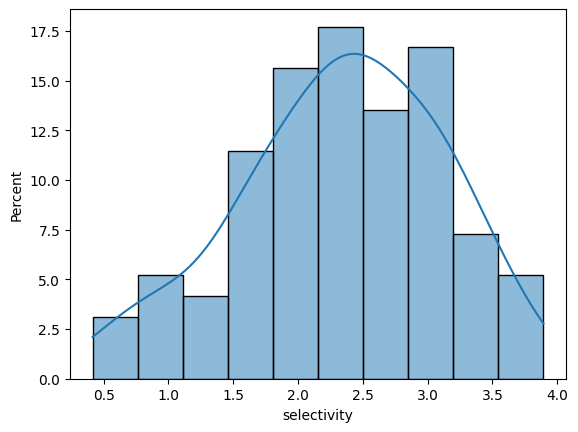

In [5]:
# target distribuition
sns.histplot(data=meta_data, x='selectivity', bins=10, kde=True, stat='percent')
plt.show()

## Embedding Extraction

The embeddings I used for the model were computed using the ESM-2 15B model and I used the mean of the last layer as the embedding.

Here's how to exytract them using the pre-trained model from esm2.  

Download the python file extract from [esm2-github](https://github.com/facebookresearch/esm), and make sure to have a conda enviromment seted up accordinly.

Then run:  
python extract.py esm2_t48_15B_UR50D data/Cumulative_Peptide_data_PG1.fasta data/embedding/esm2_15B_PG1 --repr_layers 48 --include mean

In [6]:
# # creates a empty dictionary, and updates it with the embedds
dir_path = 'data/embedding/esm2_15B_PG1/'

embeddings = {}
for file in os.listdir(dir_path):
    file_path = str(dir_path) + file 
    label = file.split('.pt')[0]
    embeddings[label] = np.array(torch.load(file_path)['mean_representations'][48])

# here I creating a dictionary with ID as key and semantic value as value 
df = meta_data.merge(pd.DataFrame.from_dict(embeddings, orient='index'), how='inner', left_on='ID', right_index=True)
df

,ID,Sequence,MBC,%Hemolysis,selectivity,0,1,2,3,4,...,5110,5111,5112,5113,5114,5115,5116,5117,5118,5119
0,PG-1.37,HVRRLCYCRRRFCACVGS,1.0,2.600000,0.414973,0.056671,-0.074099,-0.040746,0.217794,-0.197767,...,-0.130863,-0.107892,0.140624,-0.169443,0.165775,-0.120193,0.094954,-0.000617,-0.199790,0.001056
1,PG-1.20d,RGGRLRYCRRRFCVSVGR,2.0,1.607281,0.507122,0.133009,-0.124348,-0.109747,0.222604,-0.261453,...,-0.105108,-0.053451,0.092585,-0.201894,0.094672,-0.104331,0.135752,0.036512,-0.230271,0.020399
2,PG-1.62,RGGRLCYCRRRFCTCVGR,2.0,3.233927,0.810760,0.155696,-0.016959,-0.179328,0.153639,-0.241203,...,-0.160722,-0.136943,0.049061,-0.175572,0.109034,-0.239965,-0.050614,-0.096664,-0.249927,0.020688
3,PG-1.12A,RGGRLCYCRRRACVCVGR,2.0,12.103021,1.383924,0.056310,-0.137829,-0.098538,0.162526,-0.252675,...,-0.124351,-0.181434,0.037783,-0.201551,0.092573,-0.168867,0.078524,-0.003103,-0.212419,0.049512
4,PG-1.16A,RGGRLCYCRRRFCVCAGR,2.0,15.821069,1.500266,0.122564,-0.024471,-0.127546,0.165324,-0.258667,...,-0.155189,-0.155856,0.061196,-0.220575,0.092058,-0.220014,0.025014,-0.053914,-0.198191,0.036471
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,PG-1.32,HGWRLCYCRRRFCVCVGC,100.0,35.460367,3.549743,0.007245,-0.115889,-0.040796,0.235570,-0.216340,...,-0.166121,-0.146094,0.080064,-0.143502,0.155125,-0.067742,0.087349,-0.027154,-0.214921,0.023557
92,PG-1.60,RGGRLCYCRRRFCVCVGF,100.0,36.664085,3.564241,0.143025,-0.030791,-0.110694,0.109217,-0.223111,...,-0.119124,-0.189840,-0.030339,-0.218860,0.098898,-0.174355,0.023488,-0.059298,-0.252023,0.029996
93,PG-1.25,RGWRLCYCRRRFCVCVGH,100.0,46.397292,3.666493,0.068697,-0.038422,-0.142241,0.184863,-0.232976,...,-0.180917,-0.172996,0.046710,-0.179037,0.106190,-0.103997,-0.029128,0.000693,-0.243295,0.019351
94,PG-1.7,RRWCLCFCRRRFCVCVCR,100.0,51.181276,3.709111,0.066839,-0.037917,-0.087912,0.137855,-0.218455,...,-0.167717,-0.251613,-0.086687,-0.231941,0.015133,-0.017062,0.048716,-0.028251,-0.203544,-0.114390


In [7]:
# Define target and features
target = df["selectivity"]

# define features
features = df.iloc[:,meta_data.shape[1]:]
features

,0,1,2,3,4,5,6,7,8,9,...,5110,5111,5112,5113,5114,5115,5116,5117,5118,5119
0,0.056671,-0.074099,-0.040746,0.217794,-0.197767,0.223628,-0.119524,0.080779,-0.021853,0.285255,...,-0.130863,-0.107892,0.140624,-0.169443,0.165775,-0.120193,0.094954,-0.000617,-0.199790,0.001056
1,0.133009,-0.124348,-0.109747,0.222604,-0.261453,0.138052,-0.132696,0.162016,-0.073308,0.382890,...,-0.105108,-0.053451,0.092585,-0.201894,0.094672,-0.104331,0.135752,0.036512,-0.230271,0.020399
2,0.155696,-0.016959,-0.179328,0.153639,-0.241203,0.130882,-0.101294,0.178330,-0.043959,0.144877,...,-0.160722,-0.136943,0.049061,-0.175572,0.109034,-0.239965,-0.050614,-0.096664,-0.249927,0.020688
3,0.056310,-0.137829,-0.098538,0.162526,-0.252675,0.163847,-0.120923,0.205509,-0.078092,0.267088,...,-0.124351,-0.181434,0.037783,-0.201551,0.092573,-0.168867,0.078524,-0.003103,-0.212419,0.049512
4,0.122564,-0.024471,-0.127546,0.165324,-0.258667,0.142153,-0.093198,0.185513,-0.060469,0.173319,...,-0.155189,-0.155856,0.061196,-0.220575,0.092058,-0.220014,0.025014,-0.053914,-0.198191,0.036471
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,0.007245,-0.115889,-0.040796,0.235570,-0.216340,0.226666,-0.117476,0.136838,-0.047453,0.286242,...,-0.166121,-0.146094,0.080064,-0.143502,0.155125,-0.067742,0.087349,-0.027154,-0.214921,0.023557
92,0.143025,-0.030791,-0.110694,0.109217,-0.223111,0.105739,-0.079077,0.181002,-0.031332,0.150899,...,-0.119124,-0.189840,-0.030339,-0.218860,0.098898,-0.174355,0.023488,-0.059298,-0.252023,0.029996
93,0.068697,-0.038422,-0.142241,0.184863,-0.232976,0.162749,-0.080665,0.120402,-0.020260,0.204635,...,-0.180917,-0.172996,0.046710,-0.179037,0.106190,-0.103997,-0.029128,0.000693,-0.243295,0.019351
94,0.066839,-0.037917,-0.087912,0.137855,-0.218455,0.279858,-0.059348,0.068789,0.069967,0.299982,...,-0.167717,-0.251613,-0.086687,-0.231941,0.015133,-0.017062,0.048716,-0.028251,-0.203544,-0.114390


## Split data into train and test sets

In [8]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

## Running Regression Models

In [11]:
pcas = [10, 15, 20, 25, 30, 35, 40]

results_final = pd.DataFrame()
results_cv_final = pd.DataFrame()

# Instantiate LeavePOut cross-validator 
loo = LeaveOneOut()  

for num_pca in pcas:

    pca = PCA(num_pca)
    pca.fit(X_train)

    X_train_pca = pca.transform(X_train)
    X_test_pca = pca.transform(X_test)
    
    # store the results
    results = pd.DataFrame()
    results_cv = pd.DataFrame()

    # Create a list of models to test
    models = [LinearRegression(), Lasso(), SVR()]

    # Create a dictionary of hyperparameters for each model
    param_grid = [
        # LinearRegression
        {'fit_intercept': [True, False]}, 
        # Lasso
        {'alpha': np.arange(0.01, 1, 0.01),'max_iter': [10000]},
        # SVR
        {'C': [0.1, 1, 10], 'kernel': ['linear'], 'gamma': ['scale', 0.1, 0.01, 0.001]},
        ]
    
    
    # Iterate over the models and fit and predict using grid search
    for model, param_grid in zip(models, param_grid):

        # search best hyperparameter 
        grid_search = GridSearchCV(model, param_grid, scoring='r2', cv=25, n_jobs=25)

        # train in the whole training set
        grid_search.fit(X_train_pca, y_train)

        # k-fold cross-validation on the training set
        r2_cv_scores = cross_val_score(grid_search, X_train_pca, y_train, cv=25, scoring='r2', n_jobs=25)
        mae_cv_scores = cross_val_score(grid_search, X_train_pca, y_train, cv=25, scoring='neg_mean_absolute_error', n_jobs=25)

        # make predictions
        train_pred = grid_search.predict(X_train_pca)
        y_pred = grid_search.predict(X_test_pca)

        # Model evaluation on test data
        train_r2 = metrics.r2_score(y_train, train_pred)
        train_mae = metrics.mean_absolute_error(y_train, train_pred)
        train_mse = metrics.mean_squared_error(y_train, train_pred)
        train_rmse = np.sqrt(train_mse)

        # Model evaluation on test data
        test_r2 = metrics.r2_score(y_test, y_pred)
        test_mae = metrics.mean_absolute_error(y_test, y_pred)
        test_mse = metrics.mean_squared_error(y_test, y_pred)
        test_rmse = np.sqrt(test_mse)

        model_name = grid_search.best_estimator_.__class__.__name__
        embed_name = dir_path.split('/')[-2]
        best_params = str(grid_search.best_params_)

        # print best scores
        print(f"Model: {model_name}, PCA: {num_pca}, Train R2:{train_r2:.2f}, Test R2:{test_r2:.2f}, best params {best_params}")
        print("R2 CV Scores:", r2_cv_scores)
        print()

        # Saving results
        res_dict = {}
        res_dict["Embedding"] = embed_name
        res_dict["model"] = model_name
        res_dict["num_pca"] = num_pca
        res_dict["Train_R2_score"] = train_r2.round(2)
        res_dict["Train_MAE_score"] = train_mae.round(2)
        res_dict["Train_RMSE_score"] = train_rmse.round(2)

        # test scores
        res_dict["Test_R2_score"] = test_r2.round(2)
        res_dict["Test_MAE_score"] = test_mae.round(2)
        res_dict["Test_RMSE_score"] = test_rmse.round(2)
        res_dict["Test_Best_params"] = best_params

        # updating data frame with results
        results = pd.concat([results, pd.DataFrame(res_dict, index=[0])]).reset_index(drop=True)

        #save results from cross-validation
        res_cv_dict = {
            "model": [model_name for i in range(len(mae_cv_scores))],
            "num_pca": [num_pca for i in range(len(mae_cv_scores))],
            "r2_CV_scores": r2_cv_scores,
            "Mae_CV_scores": mae_cv_scores,
        }
        #updating data frame with results
        results_cv = pd.concat([results_cv, pd.DataFrame(res_cv_dict)]).reset_index(drop=True)

    
    results_final = pd.concat([results_final, results]).reset_index(drop=True)
    results_cv_final = pd.concat([results_cv_final, results_cv]).reset_index(drop=True)

# save results
results_final.to_excel('results/results_regression_selectivity_v02.xlsx')
results_cv_final.to_excel('results/results_cv_regression_selectivity_v02.xlsx')

Model: LinearRegression, PCA: 10, Train R2:0.68, Test R2:0.47, best params {'fit_intercept': True}
R2 CV Scores: [  0.10540801   0.69432802   0.27610337   0.08027821   0.55909267
   0.5028733    0.65311024   0.70113989   0.13771912  -0.39695829
  -0.10789819   0.71409008   0.55974123 -46.81034224   0.05192538
  -1.4571695   -0.30356511   0.04847738   0.74948393   0.37552903
   0.72292524  -0.26396553   0.48329991  -1.09824593   0.69375894]

Model: Lasso, PCA: 10, Train R2:0.40, Test R2:0.33, best params {'alpha': 0.12, 'max_iter': 10000}
R2 CV Scores: [-2.13731914e-01  3.91389949e-01  1.43393241e-01 -1.11312454e+00
 -3.20236974e-01  6.85359293e-01  3.72834100e-01  4.25889840e-01
 -9.34524888e-01 -1.09004223e+00  4.54092698e-01  8.45006922e-01
  4.94866019e-01 -4.51493860e+01  7.10874110e-01 -1.92045942e+00
 -3.60918825e-02  1.25308712e-02 -9.15474487e-01  5.50453428e-02
  4.39316408e-01 -2.50046690e-01  4.05251147e-01  2.89160091e-01
  6.43387492e-01]

Model: SVR, PCA: 10, Train R2:0.6

## Results Visualization

### MAE across the validation sets

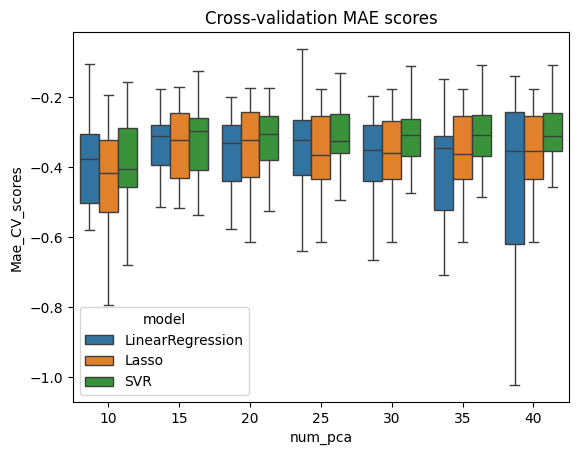

In [14]:
#results_cv_final = pd.read_excel('results/results_cv_regression_selectivity_v02.xlsx', index_col=0)
sns.boxplot(data=results_cv_final, x='num_pca', y='Mae_CV_scores', hue='model' , showfliers=False)
plt.title('Cross-validation MAE scores')
plt.show()

## R2 across the validation sets

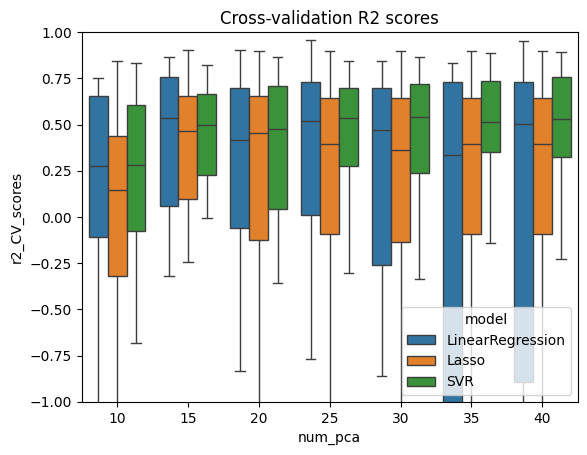

In [16]:
sns.boxplot(data=results_cv_final, x='num_pca', y='r2_CV_scores', hue='model' , showfliers=False)
plt.title('Cross-validation R2 scores')
plt.ylim(-1, 1)
plt.show()

In [31]:
results_final = pd.read_excel('results/results_regression_selectivity_v02.xlsx', index_col=0)
results_final

,Embedding,model,num_pca,Train_R2_score,Train_MAE_score,Train_RMSE_score,Test_R2_score,Test_MAE_score,Test_RMSE_score,Test_Best_params
0,esm2_15B_PG1,LinearRegression,10,0.68,0.34,0.42,0.47,0.47,0.66,{'fit_intercept': True}
1,esm2_15B_PG1,Lasso,10,0.40,0.45,0.58,0.33,0.59,0.74,"{'alpha': 0.12, 'max_iter': 10000}"
2,esm2_15B_PG1,SVR,10,0.66,0.33,0.43,0.43,0.48,0.68,"{'C': 1, 'gamma': 'scale', 'kernel': 'linear'}"
3,esm2_15B_PG1,LinearRegression,15,0.82,0.26,0.32,0.76,0.32,0.45,{'fit_intercept': True}
4,esm2_15B_PG1,Lasso,15,0.40,0.45,0.58,0.33,0.59,0.74,"{'alpha': 0.12, 'max_iter': 10000}"
5,esm2_15B_PG1,SVR,15,0.78,0.26,0.35,0.69,0.34,0.50,"{'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}"
6,esm2_15B_PG1,LinearRegression,20,0.83,0.25,0.31,0.74,0.33,0.46,{'fit_intercept': True}
7,esm2_15B_PG1,Lasso,20,0.40,0.45,0.58,0.33,0.59,0.74,"{'alpha': 0.12, 'max_iter': 10000}"
8,esm2_15B_PG1,SVR,20,0.78,0.26,0.35,0.61,0.40,0.56,"{'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}"
9,esm2_15B_PG1,LinearRegression,25,0.86,0.22,0.27,0.75,0.34,0.45,{'fit_intercept': True}


### Train x Test Model performances

In [32]:
# Reshape the dataframe to long format
melted_df = pd.melt(results_final, 
                    id_vars=['num_pca', 'model'], 
                    value_vars=['Test_R2_score', 'Train_R2_score'], 
                    var_name='Score Type', value_name='R2 Score')

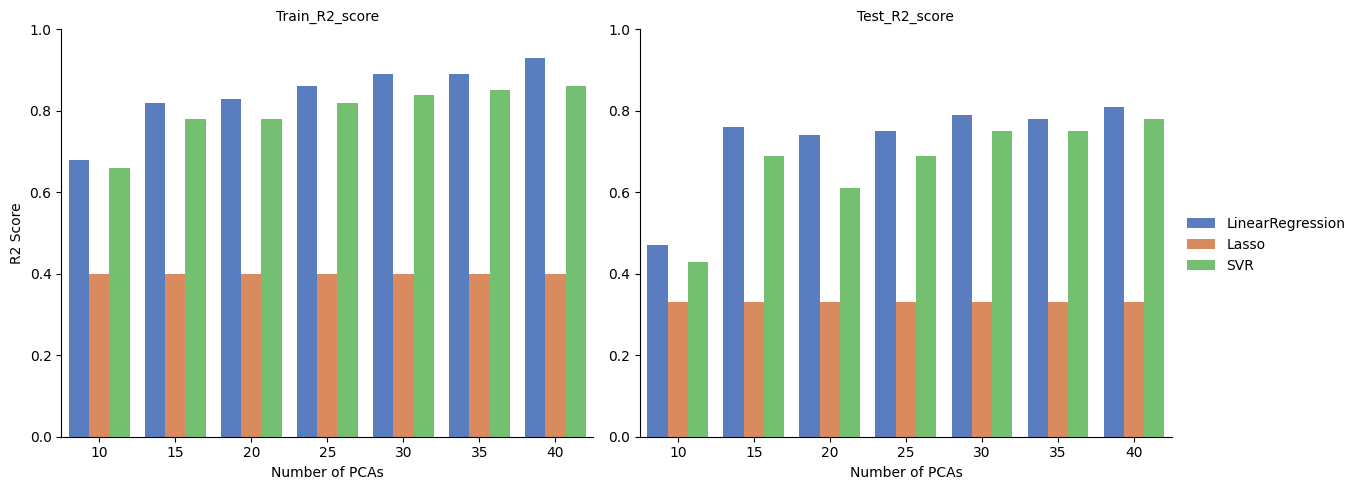

In [33]:
# Example using FacetGrid for a categorical breakdown
g = sns.FacetGrid(melted_df, col="Score Type", sharey=False, height=5, aspect=1.2, ylim=(0,1), col_order=['Train_R2_score', 'Test_R2_score'])
g.map_dataframe(sns.barplot, x="num_pca", y="R2 Score", hue='model', palette='muted')
g.set_axis_labels("Number of PCAs", "R2 Score")
g.set_titles(col_template="{col_name}", row_template="{row_name}")
g.add_legend()
plt.show()

To determine if the model is overfitting, it's important to evaluate its performance on a validation set or using cross-validation.  
If the model's performance on the validation set is significantly worse than its performance on the training set, then it may be overfitting.  
In such cases, it may be necessary to adjust the hyperparameters of the model or to use a more complex kernel function.

## Fine Tunning Model with best hyperparameter found with Gridsearch

In [34]:
results_final.query('num_pca == 15')

,Embedding,model,num_pca,Train_R2_score,Train_MAE_score,Train_RMSE_score,Test_R2_score,Test_MAE_score,Test_RMSE_score,Test_Best_params
3,esm2_15B_PG1,LinearRegression,15,0.82,0.26,0.32,0.76,0.32,0.45,{'fit_intercept': True}
4,esm2_15B_PG1,Lasso,15,0.40,0.45,0.58,0.33,0.59,0.74,"{'alpha': 0.12, 'max_iter': 10000}"
5,esm2_15B_PG1,SVR,15,0.78,0.26,0.35,0.69,0.34,0.50,"{'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}"


In [35]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

In [36]:
num_pca_components = 15

pca = PCA(num_pca_components)
pca.fit(X_train)

X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

In [37]:
# saving PCA weights
joblib.dump(pca, 'models/pca15_weights_v02.pkl')

['models/pca15_weights_v02.pkl']

### Linear Regression

In [38]:
# train support vector machine regressor
model = LinearRegression(
    fit_intercept=True
    )

# fined tuned SVR performance
model.fit(X_train_pca, y_train)

# print R2 score
print(f'Train R2 score: {model.score(X_train_pca, y_train):.2f}')
print(f'Test R2 score: {model.score(X_test_pca, y_test):.2f}')

Train R2 score: 0.82
Test R2 score: 0.76


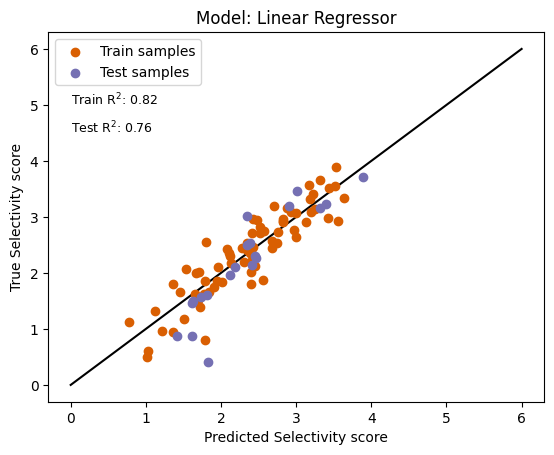

In [39]:
train_pred = model.predict(X_train_pca)
y_pred = model.predict(X_test_pca)

plt.scatter(train_pred, y_train, label="Train samples", c='#d95f02')
plt.scatter(y_pred, y_test, label="Test samples", c='#7570b3')
plt.title(f"Model: Linear Regressor")
plt.xlabel("Predicted Selectivity score")
plt.ylabel("True Selectivity score")
plt.plot([0, 6], [0, 6], c='k', zorder=0) 
plt.text(0, 5, f'Train R$^2$: {model.score(X_train_pca, y_train).round(2)}', fontsize = 9)
plt.text(0, 4.5, f'Test R$^2$: {model.score(X_test_pca, y_test).round(2)}', fontsize = 9)
plt.legend()
plt.show()

## Lasso

In [40]:
model = Lasso(
    alpha=0.12,
    max_iter=10000    
)

# fined tuned SVR performance
model.fit(X_train_pca, y_train)

# print R2 score
print(f'Train R2 score: {model.score(X_train_pca, y_train):.2f}')
print(f'Test R2 score: {model.score(X_test_pca, y_test):.2f}')

Train R2 score: 0.40
Test R2 score: 0.33


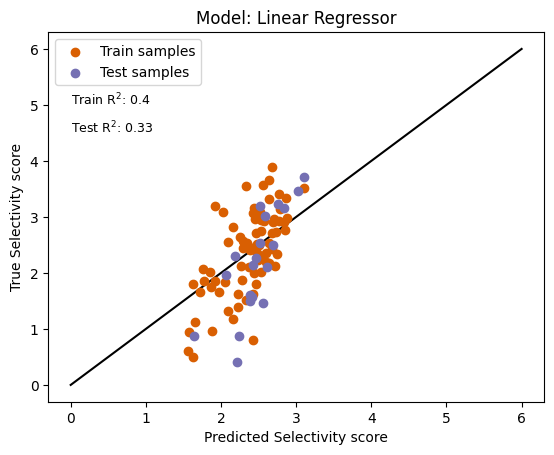

In [41]:
train_pred = model.predict(X_train_pca)
y_pred = model.predict(X_test_pca)

plt.scatter(train_pred, y_train, label="Train samples", c='#d95f02')
plt.scatter(y_pred, y_test, label="Test samples", c='#7570b3')
plt.title(f"Model: Linear Regressor")
plt.xlabel("Predicted Selectivity score")
plt.ylabel("True Selectivity score")
plt.plot([0, 6], [0, 6], c='k', zorder=0) 
plt.text(0, 5, f'Train R$^2$: {model.score(X_train_pca, y_train).round(2)}', fontsize = 9)
plt.text(0, 4.5, f'Test R$^2$: {model.score(X_test_pca, y_test).round(2)}', fontsize = 9)
plt.legend()
plt.show()

## SVR

In [42]:
# train support vector machine regressor
model = SVR(
    C=0.1, 
    gamma='scale',
    kernel='linear',
    )

# fined tuned SVR performance
model.fit(X_train_pca, y_train)

# print R2 score
print(f'Train R2 score: {model.score(X_train_pca, y_train):.2f}')
print(f'Test R2 score: {model.score(X_test_pca, y_test):.2f}')

Train R2 score: 0.78
Test R2 score: 0.69


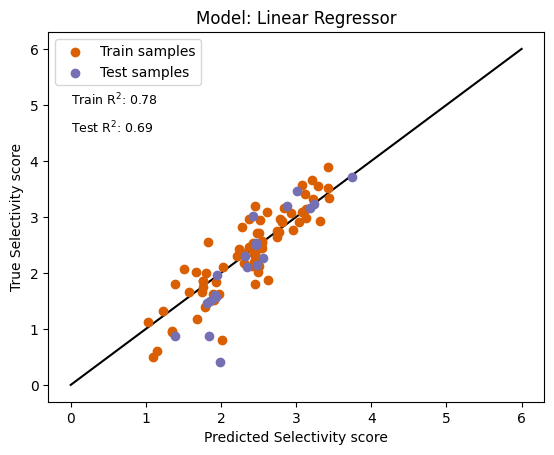

In [43]:
train_pred = model.predict(X_train_pca)
y_pred = model.predict(X_test_pca)

plt.scatter(train_pred, y_train, label="Train samples", c='#d95f02')
plt.scatter(y_pred, y_test, label="Test samples", c='#7570b3')
plt.title(f"Model: Linear Regressor")
plt.xlabel("Predicted Selectivity score")
plt.ylabel("True Selectivity score")
plt.plot([0, 6], [0, 6], c='k', zorder=0) 
plt.text(0, 5, f'Train R$^2$: {model.score(X_train_pca, y_train).round(2)}', fontsize = 9)
plt.text(0, 4.5, f'Test R$^2$: {model.score(X_test_pca, y_test).round(2)}', fontsize = 9)
plt.legend()
plt.show()

In [44]:
## save the model
joblib.dump(model, 'models/model_v02_SVR15_esm2_15B_selectivity_regression.pkl')

['models/model_v02_SVR15_esm2_15B_selectivity_regression.pkl']